
## Summary of the columns

Certainly! Here's the summary of the columns:

   - gender: Gender refers to the classification of individuals as male or female. It is an important demographic factor that can influence various aspects of health and medical conditions.

  -  age: Age represents the number of years a person has lived since birth. It provides insight into the individual's life stage, potential health risks, and susceptibility to certain diseases or conditions associated with specific age groups.

 -   hypertension: Hypertension, often referred to as high blood pressure, is a medical condition characterized by persistently elevated blood pressure in the arteries. It is a significant risk factor for various cardiovascular diseases and can lead to serious health complications if left unmanaged.

  -  heart_disease: Heart disease refers to a range of conditions affecting the heart, such as coronary artery disease, heart failure, or heart rhythm disorders. It is a broad term encompassing various cardiovascular disorders that can impact the overall functioning of the heart.

  -  smoking_history: Smoking history indicates whether an individual has a past or present habit of smoking tobacco products. Smoking is a well-known risk factor for numerous health problems, including respiratory diseases, cardiovascular diseases, and certain types of cancer.

  -  bmi: Body Mass Index (BMI) is a measure of body fat based on an individual's weight and height. It provides an estimation of whether a person's weight is within a healthy range or if they are underweight, overweight, or obese. BMI is commonly used as a screening tool for assessing the risk of weight-related health issues.

 -   HbA1c_level: HbA1c (Hemoglobin A1c) level is a laboratory test that measures the average blood sugar (glucose) levels over the past 2-3 months. It is commonly used in the diagnosis and management of diabetes. Higher HbA1c levels indicate poorer blood sugar control and may indicate the need for adjustments in diabetes treatment.

  -  blood_glucose_level: Blood glucose level refers to the concentration of glucose (sugar) in the bloodstream. It is an important indicator of an individual's blood sugar regulation. Abnormal blood glucose levels, either too high (hyperglycemia) or too low (hypoglycemia), can be associated with various health conditions, particularly diabetes.

  -  diabetes: Diabetes is a chronic medical condition characterized by elevated blood sugar levels due to insufficient insulin production or ineffective use of insulin in the body. It requires careful management and monitoring of blood sugar levels to prevent complications. Diabetes can have significant impacts on overall health and may require lifestyle modifications, medication, and regular medical care.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col,isnan, when, count
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
import findspark
from pyspark.sql import SparkSession

findspark.init()
spark = SparkSession.builder \
.master("local[4]") \
.appName("diabetes") \
.config("spark.executor.memory","4g") \
.config("spark.driver.memory","2g") \
.getOrCreate()
sc= spark.sparkContext


23/05/29 00:45:18 WARN Utils: Your hostname, kadir-HUMA resolves to a loopback address: 127.0.1.1; using 192.168.0.8 instead (on interface wlp0s20f3)
23/05/29 00:45:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/29 00:45:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Reading the dataset

In [2]:
data = spark.read \
.option("header","True") \
.option("inferSchema","True") \
.option("sep",",") \
.csv("/home/kadir/Important Documents/datasets/diabetes_prediction_dataset.csv")

In [3]:
data.limit(12).toPandas()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


In [4]:
data.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)



In [5]:
data.cache()

DataFrame[gender: string, age: double, hypertension: int, heart_disease: int, smoking_history: string, bmi: double, HbA1c_level: double, blood_glucose_level: int, diabetes: int]

## Preliminary analysis of the dataset

In [6]:
data.describe().toPandas()

23/05/29 00:45:28 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,count,100000,100000,100000,100000,100000,100000,100000,100000,100000
1,mean,None,41.88585600000013,0.07485,0.03942,None,27.32076709999422,5.5275069999983275,138.05806,0.085
2,stddev,None,22.51683987161704,0.2631504702289171,0.1945930169980986,None,6.636783416648357,1.0706720918835468,40.70813604870383,0.27888308976661896
3,min,Female,0.08,0,0,No Info,10.01,3.5,80,0
4,max,Other,80.0,1,1,not current,95.69,9.0,300,1


In [7]:


counter_for_null = 1
for column in data.columns:
    if(data.filter(col(column).isNull()).count() > 0 ):
        print(counter_for_null, ". ", column, " There is null inside")
    else:
        print(counter_for_null, column)
    counter_for_null += 1



1 gender
2 age
3 hypertension
4 heart_disease
5 smoking_history
6 bmi
7 HbA1c_level
8 blood_glucose_level
9 diabetes


##### Obervations from preliminary analysis:
- No null values in any of the columns


## Exploratory Data Analysis
##### Segregating columns into types

   - Numerical - age, bmi, HbA1c_level, blood_glucose_level
   - Categorical - hypertension, heart_disease,diabetes, gender



In [8]:
# To utilize the Seaborn library, I am converting the dataset from a Spark DataFrame to a Pandas DataFrame.
pd_df = data.toPandas() 

### Univariate analysis on age

In [9]:
pd_df.age.describe()

count    100000.000000
mean         41.885856
std          22.516840
min           0.080000
25%          24.000000
50%          43.000000
75%          60.000000
max          80.000000
Name: age, dtype: float64

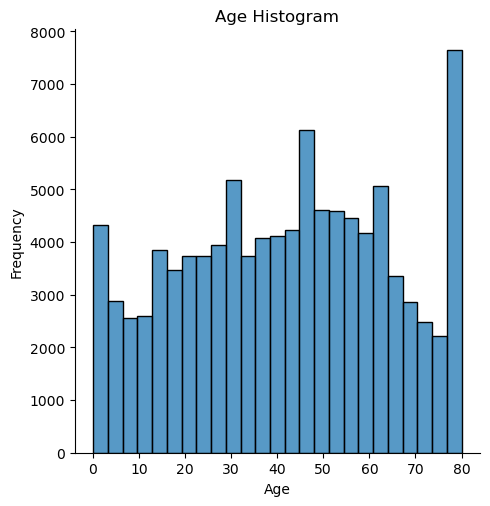

In [10]:
ax = sns.displot(data=pd_df, x='age', kind='hist', bins = 25)
ax.set(title='Age Histogram', xlabel='Age', ylabel='Frequency')

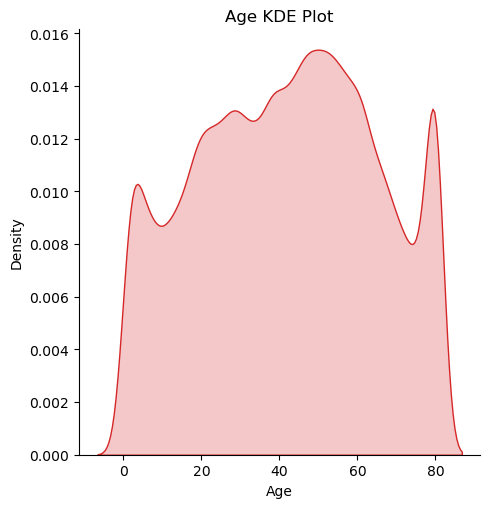

In [11]:
ax = sns.displot(data=pd_df, x='age', kind='kde', color = sns.color_palette()[3], fill=True)
ax.set(title='Age KDE Plot', xlabel='Age')

In [12]:
pd_df['age'].skew()

-0.05197899678256747

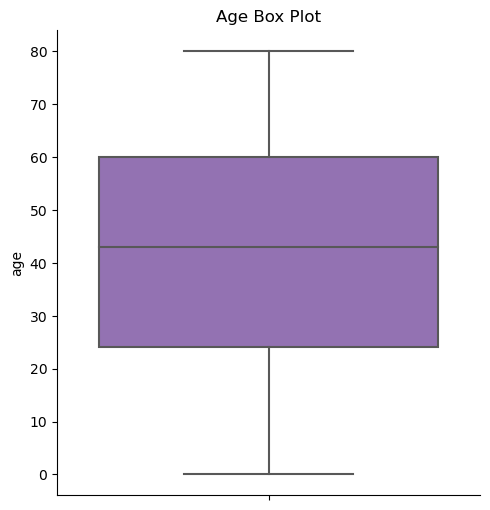

In [13]:
ax = sns.catplot(data=pd_df, y='age', kind='box',color = sns.color_palette()[4])
ax.set(title='Age Box Plot')

#### Conclusions
   - No missing values
   - No outliers
   - Data is very slightly left skewed


### Univariate analysis on bmi

In [14]:
pd_df['bmi'].describe()

count    100000.000000
mean         27.320767
std           6.636783
min          10.010000
25%          23.630000
50%          27.320000
75%          29.580000
max          95.690000
Name: bmi, dtype: float64

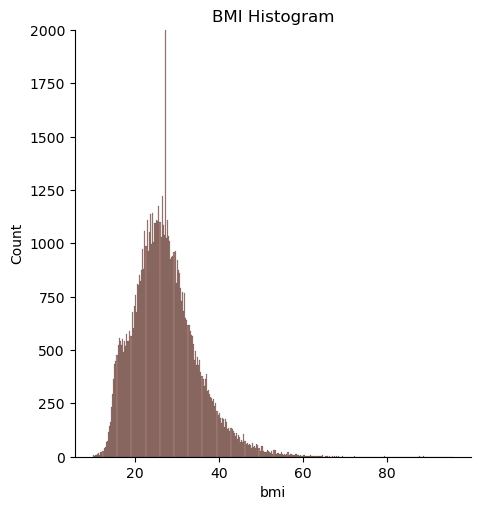

In [15]:
ax = sns.displot(data=pd_df, x='bmi', color = sns.color_palette()[5])
plt.ylim((0, 2000))
ax.set(title='BMI Histogram')

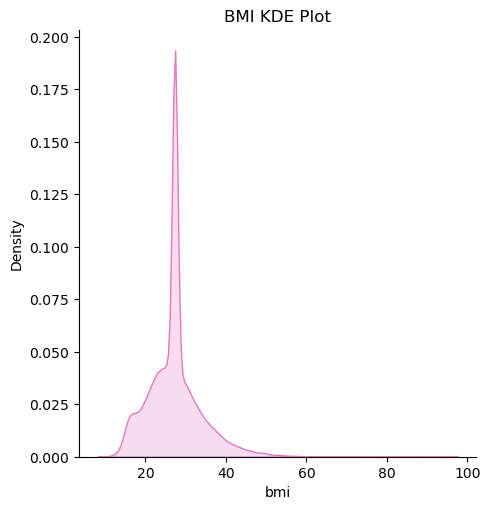

In [16]:
ax = sns.displot(data=pd_df, x='bmi', color = sns.color_palette()[6], kind='kde', fill=True)
ax.set(title='BMI KDE Plot')

In [17]:
pd_df.bmi.skew()

1.0438355183081105

In [18]:
pd_df.bmi.value_counts()

27.32    25495
23.00      103
27.12      101
27.80      100
24.96      100
         ...  
58.23        1
48.18        1
55.57        1
57.07        1
60.52        1
Name: bmi, Length: 4247, dtype: int64

In [19]:
pd_df.bmi.value_counts(normalize=True).head(10)*100

27.32    25.495
23.00     0.103
27.12     0.101
27.80     0.100
24.96     0.100
22.40     0.099
25.00     0.099
25.60     0.098
26.70     0.094
24.50     0.094
Name: bmi, dtype: float64

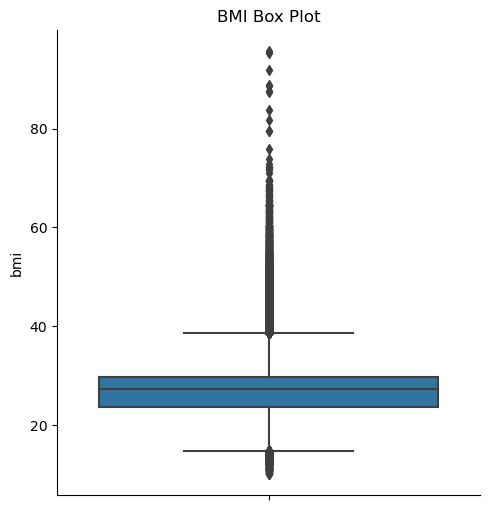

In [20]:
ax=sns.catplot(data=pd_df, y='bmi',  kind='box')
ax.set(title='BMI Box Plot')

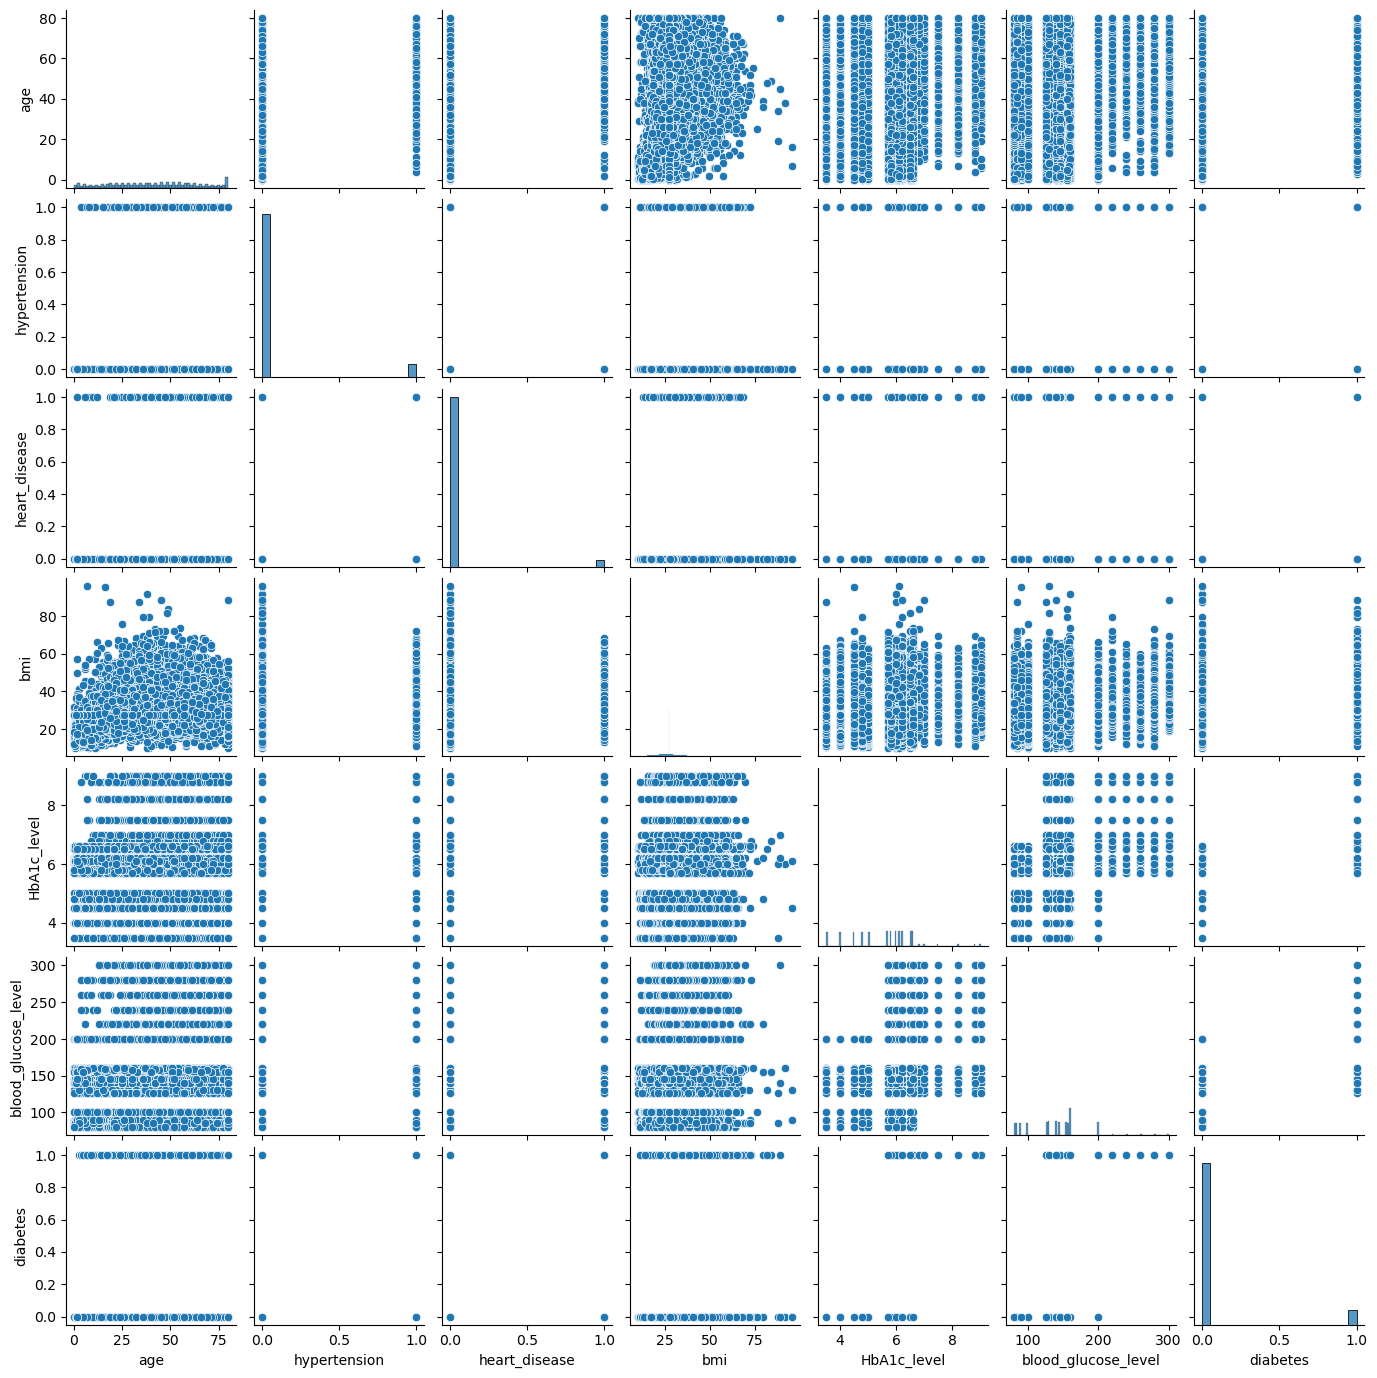

In [21]:
sns.pairplot(data = pd_df, height = 2)

In [22]:
cormat = pd_df.corr()
round(cormat,2)

/tmp/ipykernel_75953/2807160971.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cormat = pd_df.corr()


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
age,1.00,0.25,0.23,0.34,0.10,0.11,0.26
hypertension,0.25,1.00,0.12,0.15,0.08,0.08,0.20
heart_disease,0.23,0.12,1.00,0.06,0.07,0.07,0.17
bmi,0.34,0.15,0.06,1.00,0.08,0.09,0.21
HbA1c_level,0.10,0.08,0.07,0.08,1.00,0.17,0.40
blood_glucose_level,0.11,0.08,0.07,0.09,0.17,1.00,0.42
diabetes,0.26,0.20,0.17,0.21,0.40,0.42,1.00


In [23]:
data.createGlobalTempView("table")

In [24]:
data.groupBy(F.col("smoking_history")) \
.agg({"*":"count"}) \
.toPandas().head(10)

,smoking_history,count(1)
0,not current,6447
1,former,9352
2,No Info,35816
3,current,9286
4,never,35095
5,ever,4004


In [25]:
data.groupBy(F.col("gender")) \
.agg({"*":"count"}) \
.toPandas().head(10)

,gender,count(1)
0,Female,58552
1,Other,18
2,Male,41430


- People with the attribute 'Other' occupy a very small number in the gender group, so it would be more accurate to exclude them from the group.

In [26]:
data2 = data \
.filter(~(
    col("gender").contains("Other") 
))

print(data.count())
print(data2.count())

100000
99982


### string indexer

In [27]:
gender_indexer = StringIndexer() \
.setHandleInvalid("skip") \
.setInputCol("gender") \
.setOutputCol("gender_index")

In [28]:
smoking_indexer = StringIndexer() \
.setHandleInvalid("skip") \
.setInputCol("smoking_history") \
.setOutputCol("smoking_history_indexer")

In [29]:


data3 = gender_indexer.fit(data2).transform(data2)
data3 = smoking_indexer.fit(data3).transform(data3)


In [30]:
data3.toPandas().head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_index,smoking_history_indexer
0,Female,80.0,0,1,never,25.19,6.6,140,0,0.0,1.0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,0.0,0.0
2,Male,28.0,0,0,never,27.32,5.7,158,0,1.0,1.0
3,Female,36.0,0,0,current,23.45,5.0,155,0,0.0,3.0
4,Male,76.0,1,1,current,20.14,4.8,155,0,1.0,3.0
5,Female,20.0,0,0,never,27.32,6.6,85,0,0.0,1.0
6,Female,44.0,0,0,never,19.31,6.5,200,1,0.0,1.0
7,Female,79.0,0,0,No Info,23.86,5.7,85,0,0.0,0.0
8,Male,42.0,0,0,never,33.64,4.8,145,0,1.0,1.0
9,Female,32.0,0,0,never,27.32,5.0,100,0,0.0,1.0


### VectorAssembler

In [31]:

assembler = VectorAssembler() \
.setInputCols(['age', 'hypertension', 'heart_disease', 'bmi','HbA1c_level', 'blood_glucose_level', 'gender_index', 'smoking_history_indexer']) \
.setOutputCol("features")



In [32]:
assembler_df = assembler.transform(data3)

In [33]:
assembler_df.toPandas().head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_index,smoking_history_indexer,features
0,Female,80.0,0,1,never,25.19,6.6,140,0,0.0,1.0,"[80.0, 0.0, 1.0, 25.19, 6.6, 140.0, 0.0, 1.0]"
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,0.0,0.0,"(54.0, 0.0, 0.0, 27.32, 6.6, 80.0, 0.0, 0.0)"
2,Male,28.0,0,0,never,27.32,5.7,158,0,1.0,1.0,"[28.0, 0.0, 0.0, 27.32, 5.7, 158.0, 1.0, 1.0]"
3,Female,36.0,0,0,current,23.45,5.0,155,0,0.0,3.0,"[36.0, 0.0, 0.0, 23.45, 5.0, 155.0, 0.0, 3.0]"
4,Male,76.0,1,1,current,20.14,4.8,155,0,1.0,3.0,"[76.0, 1.0, 1.0, 20.14, 4.8, 155.0, 1.0, 3.0]"


### Splitting the training and test sets

In [34]:
train_df, test_df = assembler_df.randomSplit([0.8,0.2])

In [35]:
train_df.count()

80185

In [36]:
test_df.count()

19797

In [37]:
from pyspark.ml.classification import LogisticRegression

In [38]:
# Creating a classifier object
logreg_obj = LogisticRegression() \
.setLabelCol("diabetes") \
.setFeaturesCol("features")

In [39]:
logreg_model = logreg_obj.fit(train_df)

In [40]:
transformed_df = logreg_model.transform(test_df)

In [41]:
transformed_df.limit(5).toPandas().head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_index,smoking_history_indexer,features,rawPrediction,probability,prediction
0,Female,0.08,0,0,No Info,12.50,4.5,155,0,0.0,0.0,"(0.08, 0.0, 0.0, 12.5, 4.5, 155.0, 0.0, 0.0)","[10.71546353129687, -10.71546353129687]","[0.9999778014975829, 2.2198502417136723e-05]",0.0
1,Female,0.08,0,0,No Info,12.82,3.5,90,0,0.0,0.0,"(0.08, 0.0, 0.0, 12.82, 3.5, 90.0, 0.0, 0.0)","[15.16948930901053, -15.16948930901053]","[0.9999997417892094, 2.5821079063792496e-07]",0.0
2,Female,0.08,0,0,No Info,14.26,6.5,160,0,0.0,0.0,"(0.08, 0.0, 0.0, 14.26, 6.5, 160.0, 0.0, 0.0)","[5.7270068006684625, -5.7270068006684625]","[0.9967537614420449, 0.003246238557955139]",0.0
3,Female,0.08,0,0,No Info,27.32,4.8,140,0,0.0,0.0,"(0.08, 0.0, 0.0, 27.32, 4.8, 140.0, 0.0, 0.0)","[9.167716581157517, -9.167716581157517]","[0.9998956563657604, 0.00010434363423961202]",0.0
4,Female,0.16,0,0,No Info,12.30,5.8,140,0,0.0,0.0,"(0.16, 0.0, 0.0, 12.3, 5.8, 140.0, 0.0, 0.0)","[8.195311705126816, -8.195311705126816]","[0.9997241318741465, 0.0002758681258534512]",0.0


### Model Accuracy

In [42]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [43]:


evaluator = MulticlassClassificationEvaluator() \
.setLabelCol("diabetes") \
.setPredictionCol("prediction") \
.setMetricName("accuracy")



In [44]:


accuracy = evaluator.evaluate(transformed_df)



In [45]:
accuracy

0.9603475274031419